In [3]:
from numba import jit,prange,cuda #牢记prange也要导入
import numpy as np
import math
import cupy

In [4]:
@cuda.jit(device=True) #计算x方向的gradient operator
def d_dx(MatA,p_x):
    x,y=cuda.grid(2)
    return (MatA[x,y]-MatA[x-1,y])/p_x
    
@cuda.jit(device=True) #计算y方向的gradient operator
def d_dy(MatA,p_y):
    x,y=cuda.grid(2)
    return (MatA[x,y]-MatA[x,y-1])/p_y

@cuda.jit(device=True) #计算laplace operator 
def d2_dxy2(MatA,p_x,p_y):
    x,y=cuda.grid(2)
    retval=(MatA[x-1,y]-2.0*MatA[x,y]+MatA[x+1,y])/p_x/p_x+\
    (MatA[x,y-1]-2.0*MatA[x,y]+MatA[x,y+1])/p_y/p_y
    return retval

@cuda.jit
def kernel_pbc(MatA): 
    x,y=cuda.grid(2)
    row1,col1=MatA.shape
    if x==0:
        MatA[x,y]=MatA[row1-2,y]
    elif x==row1-1:
        MatA[x,y]=MatA[1,y]
    elif y==0:
        MatA[x,y]=MatA[x,col1-2]
    elif y==col1-1:
        MatA[x,y]=MatA[x,1]
    else:
        MatA[x,y]=MatA[x,y]
    
@cuda.jit
def kernel_ass(MatA,MatB):
    x,y=cuda.grid(2)
    MatA[x,y]=MatB[x,y]
    
@cuda.jit
def kernel_core(MatA,MatB,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,MatC,MatD): #dx->p10,dy->p11
    x,y=cuda.grid(2)
    if (x>0) and (x<MatA.shape[0]-1) and (y>0) and (y<MatA.shape[1]-1):
        Consumption=p1*MatA[x,y]*MatB[x,y] #c->p1
        dAdt=(p2*(p0-MatA[x,y])-Consumption/p3-p4*d_dy(MatA,p11)) #f->p2,h->p3,V->p4,Aup->p0
        dMdt=(p5*Consumption-p6*MatB[x,y]*p7/(p7+MatB[x,y])+p8*d2_dxy2(MatB,p10,p11)) #e->p5,dM->p6,kM->p7,D->p8
        MatC[x,y]=MatA[x,y]+dAdt*p9 #dT->p9
        MatD[x,y]=MatB[x,y]+p12*dMdt*p9 #dT->p9,Phi->p12
    else:
        MatC[x,y]=MatA[x,y]
        MatD[x,y]=MatB[x,y]

In [5]:
def mussel_regular_pattern():
    # Algal Exchange parameters
    Aup      =  np.float32(1.1)       # g/m3  Algal concentration in upper layer  Oosterschelde data
    h        =  np.float32(0.10)      # m     Height of the lower layer  defined
    f        =  np.float32(100.0)     # m3/m3/h  Phichange rate with upper layer  Guestimated

    # Mussel update, growth & mortality parameters
    c        =  np.float32(0.1)       # g/g/h Maximal consumption rate of the mussels  Riisgard 2001 
    e        =  np.float32(0.2)       # g/g   Trophic efficiency of mussels  Lamie
    dM       =  np.float32(0.02)      # g/g/h Density dependent mortality rate of the mussels  Calibrated
    kM       =  np.float32(150.0)     # g/m2  Effect of density on mortality  Guestimated

    # Spatial movement parameters
    D        =  np.float32(0.0005)    # m2/h  The diffusion constant describing the movement of mussels
    V        =  np.float32(0.1*60*60) # m/h   Tidal advection constant(0.1 m/s * 60 sec * 60 min)

    # The speeding constant Phi 
    Phi      =  np.float32(1000.0)    # Speeding constant, accelerates mussel growth

    # Simulation settings 
    length   = np.float32(50.0)       # m Length of the physical landscape
    Size     = np.int32(512)        # Size of the 2D grid

    # Simulation steps
    EndTime  = np.float32(180*24/Phi) # Total simulation time
    #NumPlots = 100         # Number of times the figure is updated
    dT       = np.float32(0.0002)     # Time step
    #计算了EndTime/dT=21600步

    # Precalculations
    dx = np.float32(length/Size)      # Spatial step size
    dy = np.float32(length/Size)      # Spatial step size

    # Set CUDA parameters 
    threadsperblock=(32,32)
    blockspergrid_x=math.ceil(Size/threadsperblock[0])
    blockspergrid_y=math.ceil(Size/threadsperblock[1])
    blockspergrid=(blockspergrid_x,blockspergrid_y)

    # %% Defining the initial values
    A = np.zeros((Size,Size))+Aup
    M = (np.random.rand(Size,Size) < 0.05) * 100.0+100.0
    A_host = A.astype(np.float32)
    M_host = M.astype(np.float32)
    A_device = cupy.asarray(A_host)
    P_A_device = cupy.empty(shape=(Size,Size),dtype=np.float32)
    M_device = cupy.asarray(M_host)
    P_M_device = cupy.empty(shape=(Size,Size),dtype=np.float32)

    for k in range(int(EndTime/dT)):
        kernel_core[blockspergrid,threadsperblock](A_device,M_device,Aup,c,f,h,V,e,dM,kM,D,dT,dx,dy,Phi,P_A_device,P_M_device)
        kernel_ass[blockspergrid,threadsperblock](A_device,P_A_device)
        kernel_ass[blockspergrid,threadsperblock](M_device,P_M_device)
        kernel_pbc[blockspergrid,threadsperblock](A_device)
        kernel_pbc[blockspergrid,threadsperblock](M_device)
    M=cupy.asnumpy(M_device)
    return M

In [6]:
import matplotlib.pyplot as plt
#M=cupy.asnumpy(M_device)
M=mussel_regular_pattern()
#plt.contourf(M)
#plt.show()

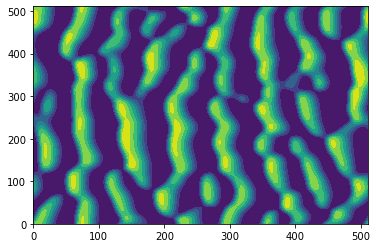

In [7]:
plt.contourf(M)
plt.show()

In [8]:
%timeit mussel_regular_pattern()

36.3 s ± 266 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
